# Logistic Regression

As linear regression is a good starting point for regression tasks, logisti regression is a nice baseline for classification tasks. Being similar to linear regression, logistic models are easy to fit and to interpret.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

## Simple Logistic Regression

We will start with the simplest possible logistic regression, where only one feature is considered. Then, the model is:
$$
P(Y=1 | X=x) = \frac{e^{\beta x}}{1+e^{\beta x}} = \frac{e^{\beta_0 + \beta_1x_1}}{1+e^{\beta_0 + \beta_1x_1}}.
$$

We will build a dataset which is linearly separable.

In [ ]:
rng = np.random.RandomState(42)
x = np.concatenate([3 * rng.rand(50), 10 - 3 * rng.rand(50)])
y = np.array([0] * 50 + [1] * 50)
plt.scatter(x, y);

We can use Scikit-Learn's ``LinearRegression`` estimator to fit this data and construct the best-fit line:

In [ ]:
from sklearn.linear_model import LogisticRegression


def plot_fitted_logistic(
    fitted_model: LogisticRegression, x: np.array, y: np.array
) -> None:
    xproba = np.linspace(0, 10, 1000)
    yproba = fitted_model.predict_proba(xproba[:, np.newaxis])[:, 1]
    ypred = fitted_model.predict(x[:, np.newaxis])

    prediction_is_1 = (ypred > 0.5).astype("int")
    predicted_proba_is_one_half = 10 * sum(yproba < 0.5) / 1000

    plt.scatter(x, y, c=prediction_is_1, cmap="Paired")
    plt.axvline(x=predicted_proba_is_one_half, linestyle="--", color="gray")
    plt.plot(xproba, yproba)

In [ ]:
model = LogisticRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], y)
plot_fitted_logistic(model, x, y)

The logistic function is here so steep that is looks like a step function - even if it is not! We can have a look to the models parameters:

In [ ]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

As with linear regression, we can also use `statsmodels`, which provides deeper statistical information and allows for greater analysis.

However, this was way too easy. Let's try to prevent a perfect separation.

In [ ]:
x = np.concatenate([6 * rng.rand(50), 10 - 6 * rng.rand(50)])
y = np.array([0] * 50 + [1] * 50)

model.fit(x[:, np.newaxis], y)

plot_fitted_logistic(model, x, y)

We can also consider this other example

In [ ]:
x = np.concatenate([2 * rng.rand(50), 4 + 2 * rng.rand(50), 10 - 2 * rng.rand(50)])
y = np.array([0] * 50 + [1] * 50 + [0] * 50)

model.fit(x[:, np.newaxis], y)

plot_fitted_logistic(model, x, y)

However, in this case it may be useful to apply the same trick adopted for linear regression and use basis functions. Polynomials, for instance. 

In [ ]:
model.fit(np.array([x, x**2]).T, y)

xproba = np.linspace(0, 10, 1000)
yproba = model.predict_proba(np.array([xproba, xproba**2]).T)[:, 1]
ypred = model.predict(np.array([x, x**2]).T)

prediction_is_1 = (ypred > 0.5).astype("int")

plt.scatter(x, y, c=prediction_is_1, cmap="Paired")
plt.plot(xproba, yproba);

The trick was made possible by the fact that, in the two-dimensional space spanned by $x$ and $x^2$, the classes are linearly separable. 

In [ ]:
xproba_100 = np.linspace(0, 10, 100)

x_mesh, x2_mesh = np.meshgrid(xproba_100, xproba_100**2)
predicted_proba_mesh = np.zeros_like(x_mesh)
for i in range(x_mesh.shape[0]):
    for j in range(x_mesh.shape[1]):
        sample = np.array([x_mesh[i, j], x2_mesh[i, j]]).reshape(1, -1)
        predicted_proba_mesh[i, j] = model.predict_proba(sample)[
            :, 1
        ]  # predicting every value in a loop is very inefficient, don't do it in a real analysis.

plt.contourf(x_mesh, x2_mesh, predicted_proba_mesh, 100)
plt.scatter(x, x**2, c=y, cmap="Paired");

In the previous chart, dots represent the samples, while the shadow the value of the model-predicted probabilities. Back means probability 1, white indicates probability 0.

If basis functions are so effective, one may think about using more and more. This leads to overfitting, and calls for regularization. 

However, there is another way: using kernels, that is functions which represent similarity in spaces spanned by infinitely many basis functions. This is outside the scope of this course, but you may find a great discussion in Elements of Statistical Learning.

## Example: predicting diabetes
We are given some clinical and anagraphic features for a bunch of patients. We want to detect the ones affected by diabetes.

### Dataset 
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. 

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

More information here: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.

## Data Exploration & Preparation
We install the latest version of plotly


In [ ]:
! pip install --upgrade plotly

### Importing data
We use pandas to read the data.

In [ ]:
import pandas as pd

diabetes_raw = pd.read_csv(
    "https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv"
)
diabetes_raw.head()

First, let us check if there are really no missing data.

In [ ]:
diabetes_raw.isna().sum()

Then, let us check the standard summary of the dataset.



In [ ]:
diabetes_raw.describe().T

There is something wierd about all those zeros as minimum values. Glucose, blod pressure, BMI, skin thickness, and insuline cannot be zero: we do not believe these are real values. 

In the real world, we would have two options:
- we replace the zeros with reasonable values or,
- we drop the rows.

When dealing with a large enough dataset, dropping is usually the best option, as it does not introduce unnecessary bias.

However, here we prefer to replace, so that we keep enough data to creare reasonable plots and analyses.

In order to understand how to impute the data, we plot the univariate distributions.


In [ ]:
diabetes_raw.hist(bins=30);

We see that Glucose and BloodPressure do not have meaningful outliers apart from 0, while the other three variables interested by the strange zeros have. Therefore, we choose the mean for Glucose and BloodPressure and the median for all the other variables.

In [ ]:
diabetes_df = diabetes_raw.copy()
diabetes_df.loc[:, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] = (
    diabetes_df.loc[
        :, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    ].replace(0, np.NaN)
)
diabetes_df = diabetes_df.fillna(
    {
        "Glucose": diabetes_df["Glucose"].mean(),
        "BloodPressure": diabetes_df["BloodPressure"].mean(),
        "SkinThickness": diabetes_df["SkinThickness"].median(),
        "Insulin": diabetes_df["Insulin"].median(),
        "BMI": diabetes_df["BMI"].median(),
    }
)

In [ ]:
sns.pairplot(diabetes_df, hue="Outcome");

We see that Glucose may be the most important variable, as its distribution conditional to the outcome has the minumum overlap. 

We also note that the variables have weak correlation among themselves, which is good for a linear model.



### Data Preparation

All the variables are numeric, and we want to use all of them: therefore, we are going to generate the train and test dataset. We go for a random 80/20 split, but we stratify on the outcome.

In [ ]:
from sklearn.model_selection import train_test_split

x = diabetes_df.drop(columns="Outcome")
y = diabetes_df.Outcome

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42, stratify=y
)

### Modelling & evaluation

We will use a simple logistic regression model.

We train the model and we evaluate its out-of-sample performances using the confusione matrix and other classification metrics.

In [ ]:
from sklearn.linear_model import LogisticRegression

cls = LogisticRegression(
    penalty="l2", solver="liblinear", C=10000, random_state=42
)  # C is the inverse of lambda
cls.fit(x_train, y_train)
pred = cls.predict(x_test)
pd.crosstab(y_test, pred, rownames=["True"], colnames=["Predicted"])

We are doing well on the real negative, but we are getting way too many false negatives. It may be that we are missing some non-linear relationship or that we just do not have enough information in the dataset.

A useful tool is having a look to the classification report by sklearn, which recaps many useful metrics.

See the [Stanford website](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-machine-learning-tips-and-tricks) for a refresher on classification metrics.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")
print(f"Precision: {precision_score(y_test, pred):.4f}")
print(f"Recall: {recall_score(y_test, pred):.4f}")
print(f"F1: {f1_score(y_test, pred):.4f}")

Finally, we have a look at the Receiver Operating Characteristic (ROC) curve.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_proba = cls.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, pred_proba)
auc = roc_auc_score(y_test, pred_proba)
plt.plot(fpr, tpr)
plt.title(f"ROC curve - AUC {auc:.3f}")
plt.show()

Here is a quick recap of what the ROC curve is: the change in true positive rate and false positive rate as a function of the decision threshold.

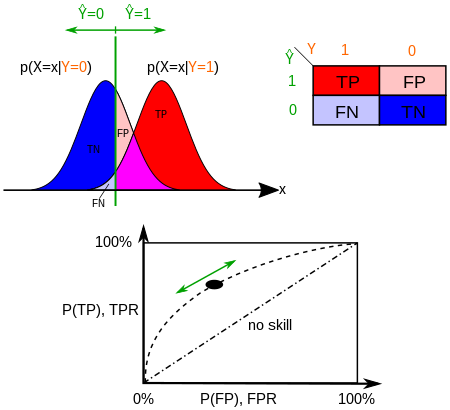